In [65]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import random


this PyTorch GAN model generate chinese number characters. 
```
{
  0: "十",
  1: "一",
  2: "二",
  3: "三",
  4: "四",
  5: "五",
  6: "六",
  7: "七",
  8: "八",
  9: "九",
}
```


In [66]:

train_images = []
totalImages = os.listdir( os.getcwd()+"/MNIST-CH")
 
for index in range(len(totalImages)):
    image = totalImages[index]
    if image.endswith(".jpg"):
        for n in range(10):
            train_images.append(image)

random.shuffle(train_images)

print(len(train_images))

2100


In [67]:

class MNIST_CH_Dataset(torch.utils.data.Dataset):
    def __init__(self,img_dir,images,transforms=None):
        self.img_dir = img_dir
        self.inputs = images
        self.transforms = transforms
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.inputs[idx])
        input = torchvision.io.read_image(img_path)
        if self.transforms:
            input = self.transforms(input)
        input = input.view(-1, 32)
       
        target =torch.tensor(int(self.inputs[idx].split('.')[-2][-1] ))
        return input,target
    
transform_train = transforms.Compose([
                                      transforms.RandomRotation(10),
                                      transforms.RandomCrop(32),
                                      # transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomAffine(0, translate=(0.1, 0.1)),
                                      transforms.ConvertImageDtype(dtype=torch.float32),
                                      transforms.Normalize(mean=(0.5,),
                                            std=(0.5,))
                                      ])

torch.Size([32, 32])
tensor([-0.9922, -0.9922, -0.9922, -0.9922, -0.9922, -0.9922, -0.9216, -1.0000,
        -0.9922, -0.7412, -0.5686,  1.0000,  1.0000,  0.9529,  0.9686,  0.5608,
         0.3098, -0.9922, -0.9922, -0.9922, -0.9922, -0.9922, -0.9922, -0.9922,
        -0.9922, -0.9922, -0.9922, -0.9922, -0.9922, -0.9922, -1.0000, -1.0000]) tensor(1.) tensor(-1.) tensor(1)


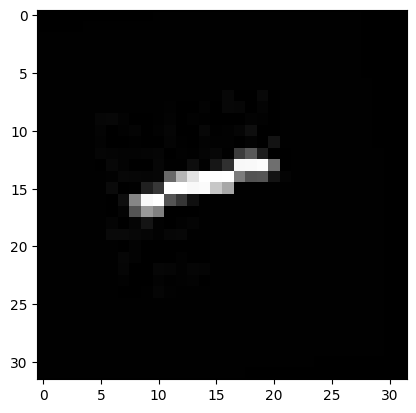

In [68]:
batch_size = 70

train_dataset = MNIST_CH_Dataset(img_dir=os.getcwd()+"/MNIST-CH",  images=train_images, transforms=transform_train )

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)


testInput,target = train_dataset.__getitem__(2)
print(testInput.shape)
print(testInput[15],testInput.max(),testInput.min(),target)
plt.imshow(testInput,cmap='gray')

In [69]:
discriminator = nn.Sequential(
    nn.Linear(1024, 784),
    nn.LeakyReLU(0.2),
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [70]:
latent_dim = 60
generator = nn.Sequential(
    nn.Linear(latent_dim, 128),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(128, momentum=0.7),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    # nn.LeakyReLU(0.2),
    # nn.BatchNorm1d(1024, momentum=0.7),
    # nn.Linear(1024, 784),
    nn.Tanh()
)

In [71]:
criterion = nn.BCEWithLogitsLoss()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [72]:
def scale_image(img):
  out = (img + 1) / 2
  return out

In [73]:
ones_ = torch.ones(batch_size, 1)
zeros_ = torch.zeros(batch_size, 1)

# save losses
discriminator_losses = []
generator_losses = []
n_epochs = 1000

for epoch in range(n_epochs):
  for inputs, _ in train_dataloader:
  
    n = inputs.size(0)
    inputs = inputs.reshape(n, 1024)
    
    ones = ones_[:n]
    zeros = zeros_[:n]
    
    # print(zeros.shape)
    
    # train discriminator 
    # real image from training dataset
    real_outputs = discriminator(inputs)
    discriminator_loss_real = criterion(real_outputs, ones)
    
    #  assume all generated images are fake
    noise = torch.randn(n, latent_dim)
    fake_images = generator(noise)
    fake_outputs = discriminator(fake_images)
    discriminator_loss_fake = criterion(fake_outputs, zeros)
    
    # gradient descent step
    d_loss = 0.5 * (discriminator_loss_real + discriminator_loss_fake)
    discriminator_optimizer.zero_grad()
    generator_optimizer.zero_grad()
    d_loss.backward()
    discriminator_optimizer.step()
    
    # train generator 
    for _ in range(2):
      noise = torch.randn(n, latent_dim)
      fake_images = generator(noise)
      
      fake_outputs = discriminator(fake_images)
     
      #  assume all generated images are true
      g_loss = criterion(fake_outputs, ones)
     
      # gradient descent step
      discriminator_optimizer.zero_grad()
      generator_optimizer.zero_grad()
      g_loss.backward()
      generator_optimizer.step()
      
    discriminator_losses.append(d_loss.item())
    generator_losses.append(g_loss.item())
  if (epoch + 1) % 10 == 0:
    print(f'Epoch {epoch+1}/{n_epochs}, discriminator Loss: {d_loss:.4f}, generator Loss: {g_loss:.4f}')
  if (epoch + 1) % 200 == 0:
    fake_images = fake_images.reshape(-1, 1, 32, 32)
    save_image(scale_image(fake_images), f"temp/{epoch + 1}.png")


Epoch 10/1000, discriminator Loss: 0.7525, generator Loss: 1.1720
Epoch 20/1000, discriminator Loss: 0.6861, generator Loss: 0.7084
Epoch 30/1000, discriminator Loss: 0.6963, generator Loss: 0.6938
Epoch 40/1000, discriminator Loss: 0.6850, generator Loss: 0.7039
Epoch 50/1000, discriminator Loss: 0.6859, generator Loss: 0.7144
Epoch 60/1000, discriminator Loss: 0.6701, generator Loss: 0.7281
Epoch 70/1000, discriminator Loss: 0.6820, generator Loss: 0.7236
Epoch 80/1000, discriminator Loss: 0.6913, generator Loss: 0.7078
Epoch 90/1000, discriminator Loss: 0.6847, generator Loss: 0.7041
Epoch 100/1000, discriminator Loss: 0.6919, generator Loss: 0.7032
Epoch 110/1000, discriminator Loss: 0.3410, generator Loss: 1.5595
Epoch 120/1000, discriminator Loss: 0.7280, generator Loss: 1.0025
Epoch 130/1000, discriminator Loss: 0.6760, generator Loss: 0.6983
Epoch 140/1000, discriminator Loss: 0.6571, generator Loss: 0.7291
Epoch 150/1000, discriminator Loss: 0.6272, generator Loss: 0.9132
Epoc

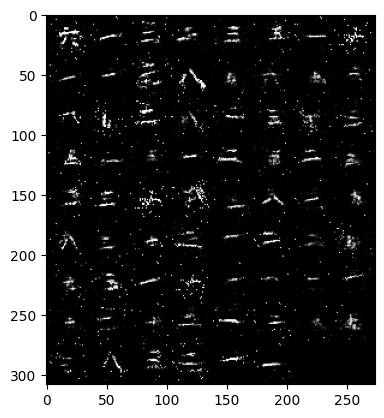

In [79]:
generator.eval()
discriminator.eval()
noise = torch.randn(n, latent_dim)
fake_images = generator(noise)
fake_images = fake_images.reshape(-1, 1, 32, 32)
save_image(scale_image(fake_images), f"temp/temp.png")

result_Image = torchvision.io.read_image(f"temp/temp.png")
plt.imshow(result_Image[0],cmap='gray')
# from skimage.io import imread
# a = imread('temp.png')
# plt.imshow(a)

torch.Size([1, 60])
torch.Size([1, 1, 32, 32])


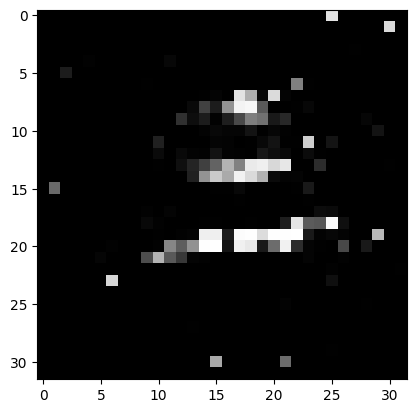

In [140]:
noise = torch.randn(1,latent_dim)
print(noise.shape)
fake_images = generator(noise)
fake_images = fake_images.reshape(-1, 1, 32, 32)
print(fake_images.shape)

save_image(scale_image(fake_images), f"temp/single.png")

result_Image = torchvision.io.read_image(f"temp/single.png")
plt.imshow(result_Image[0],cmap='gray')

In [141]:
#  save
FILE_NAME = "MNIST-CH-Generator.pth"

torch.save(generator,FILE_NAME)